In [11]:
%config InlineBackend.figure_format = 'retina'
#setup
data_dir='../../Data/Weather'
file_index='SSSSSSBB'
m='TOBS'

## Reconstruction using top eigen-vectors
For measurement = {{m}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [3]:
#%matplotlib inline
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.12.0 	required version>=1.12.0
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [4]:
from pyspark import SparkConf

In [5]:
conf = SparkConf()
conf = conf.setAppName("temp1")
conf = conf.setMaster("local")
conf = conf.set("spark.driver.host", "localhost")

In [6]:
from pyspark import SparkContext
#sc.stop()

# sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])
# For no Internet circumstance.
sc = SparkContext(conf=conf, master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





## Read Statistics File

In [7]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [8]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    371.9| 33.5333|-113.1667|       TOBS|USC00023852|     7|[40 56 E0 50 00 5...|1970.0|SSSSSSBB|
|    371.9| 33.5333|-113.1667|       TOBS|USC00023852|     3|[A0 56 30 55 80 5...|1971.0|SSSSSSBB|
|    371.9| 33.5333|-113.1667|       TOBS|USC00023852|    14|[80 54 A0 53 F0 5...|1973.0|SSSSSSBB|
|    371.9| 33.5333|-113.1667|       TOBS|USC00023852|    10|[40 56 20 50 30 5...|1974.0|SSSSSSBB|
|    371.9| 33.5333|-113.1667|       TOBS|USC00023852|     8|[30 54 30 54 30 5...|1975.0|SSSSSSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

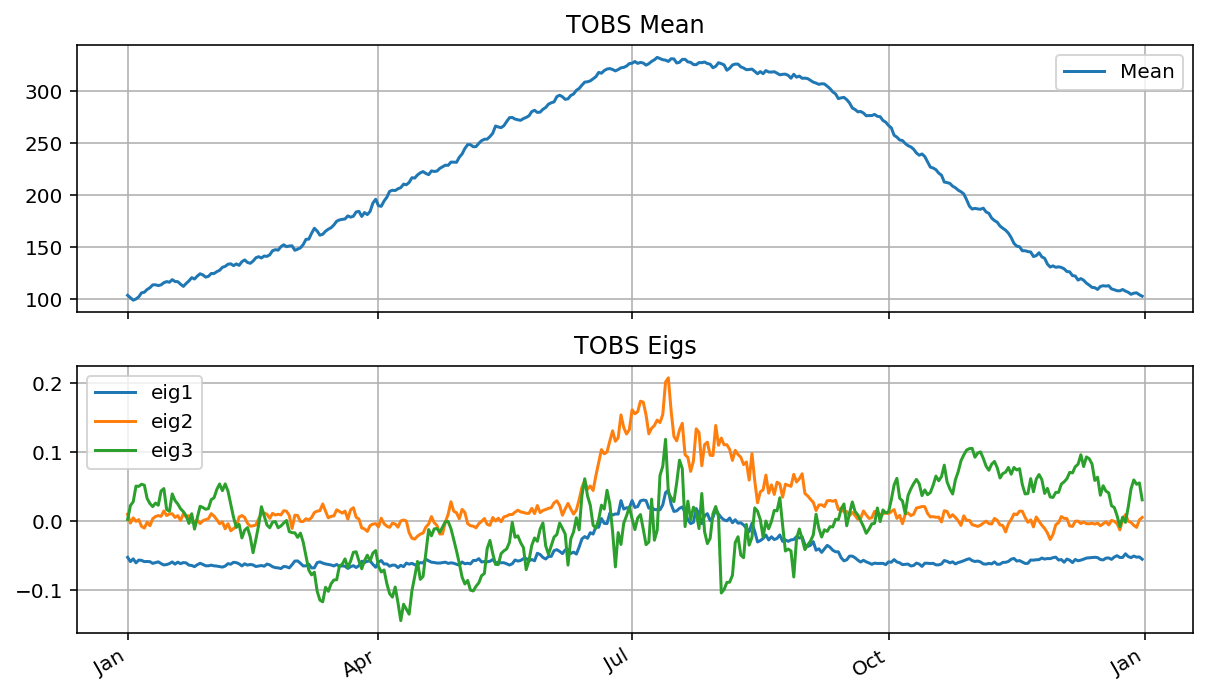

In [94]:
import pylab as plt
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

In [55]:
v=[np.array(EigVec[:,i]).flatten() for i in range(np.shape(EigVec)[1])]

### plot the percent of residual variance on average

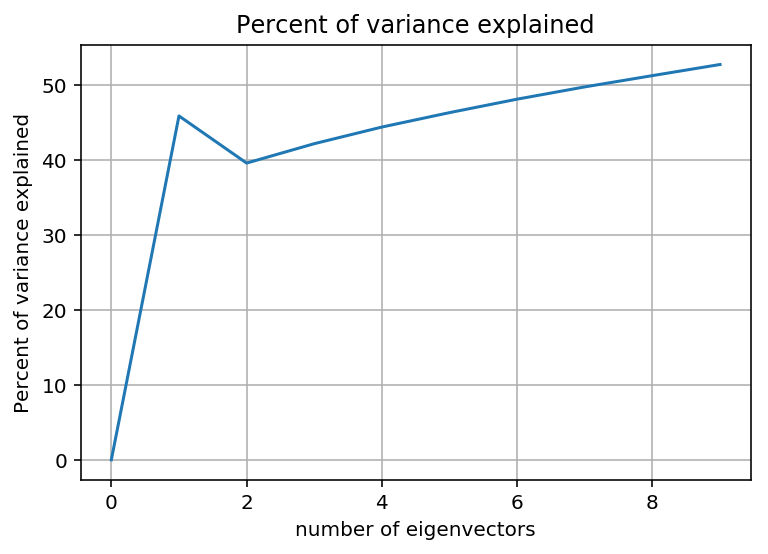

In [56]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=np.cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Process whole dataframe to find best and worse residuals

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [57]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [58]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

before filter 1271
after filter 1271


In [59]:
df

DataFrame[elevation: double, latitude: double, longitude: double, measurement: string, station: string, undefs: bigint, vector: binary, year: double, label: string]

In [60]:
# Sort entries by increasing values of ers_3
df3=df3.sort(df3.res_3,ascending=True)

In [66]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=4, row_n=3, figsize=(15,10)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            #_title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
            #        %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            #print i,j,_title,axes[i,j]
            plot_decomp(row,Mean,v,fig=fig,ax=axes[i,j],interactive=False)
    return None


#### Different things to try
The best/worst rows in terms of res_mean,res_1, res_2, res_3

The rows with the highest lowest levels of coeff1, coeff2, coeff3, when the corresponding residue is small.

In [104]:
df5=df3.filter(df3.res_1<0.4).sort(df3.coeff_1)
rows=df5.take(12)
df5.select('coeff_1','res_1').show(10)

+-------------------+-------------------+
|            coeff_1|              res_1|
+-------------------+-------------------+
| -1306.581901091773|0.28590281718451055|
|-1288.2430641047688|  0.358939511793947|
|-1287.9496894172648| 0.2560720453616022|
|-1277.2112376439395|0.27983515094043715|
|-1261.8837074378675| 0.3463761543579861|
| -1218.672424968076|0.36654456941891833|
|-1190.7843076846602| 0.3633259253206242|
|-1163.2943107444376|0.35700260453004895|
|-1160.3966834067655| 0.3118986617593473|
| -1154.143885944556|0.32838678630337886|
+-------------------+-------------------+
only showing top 10 rows



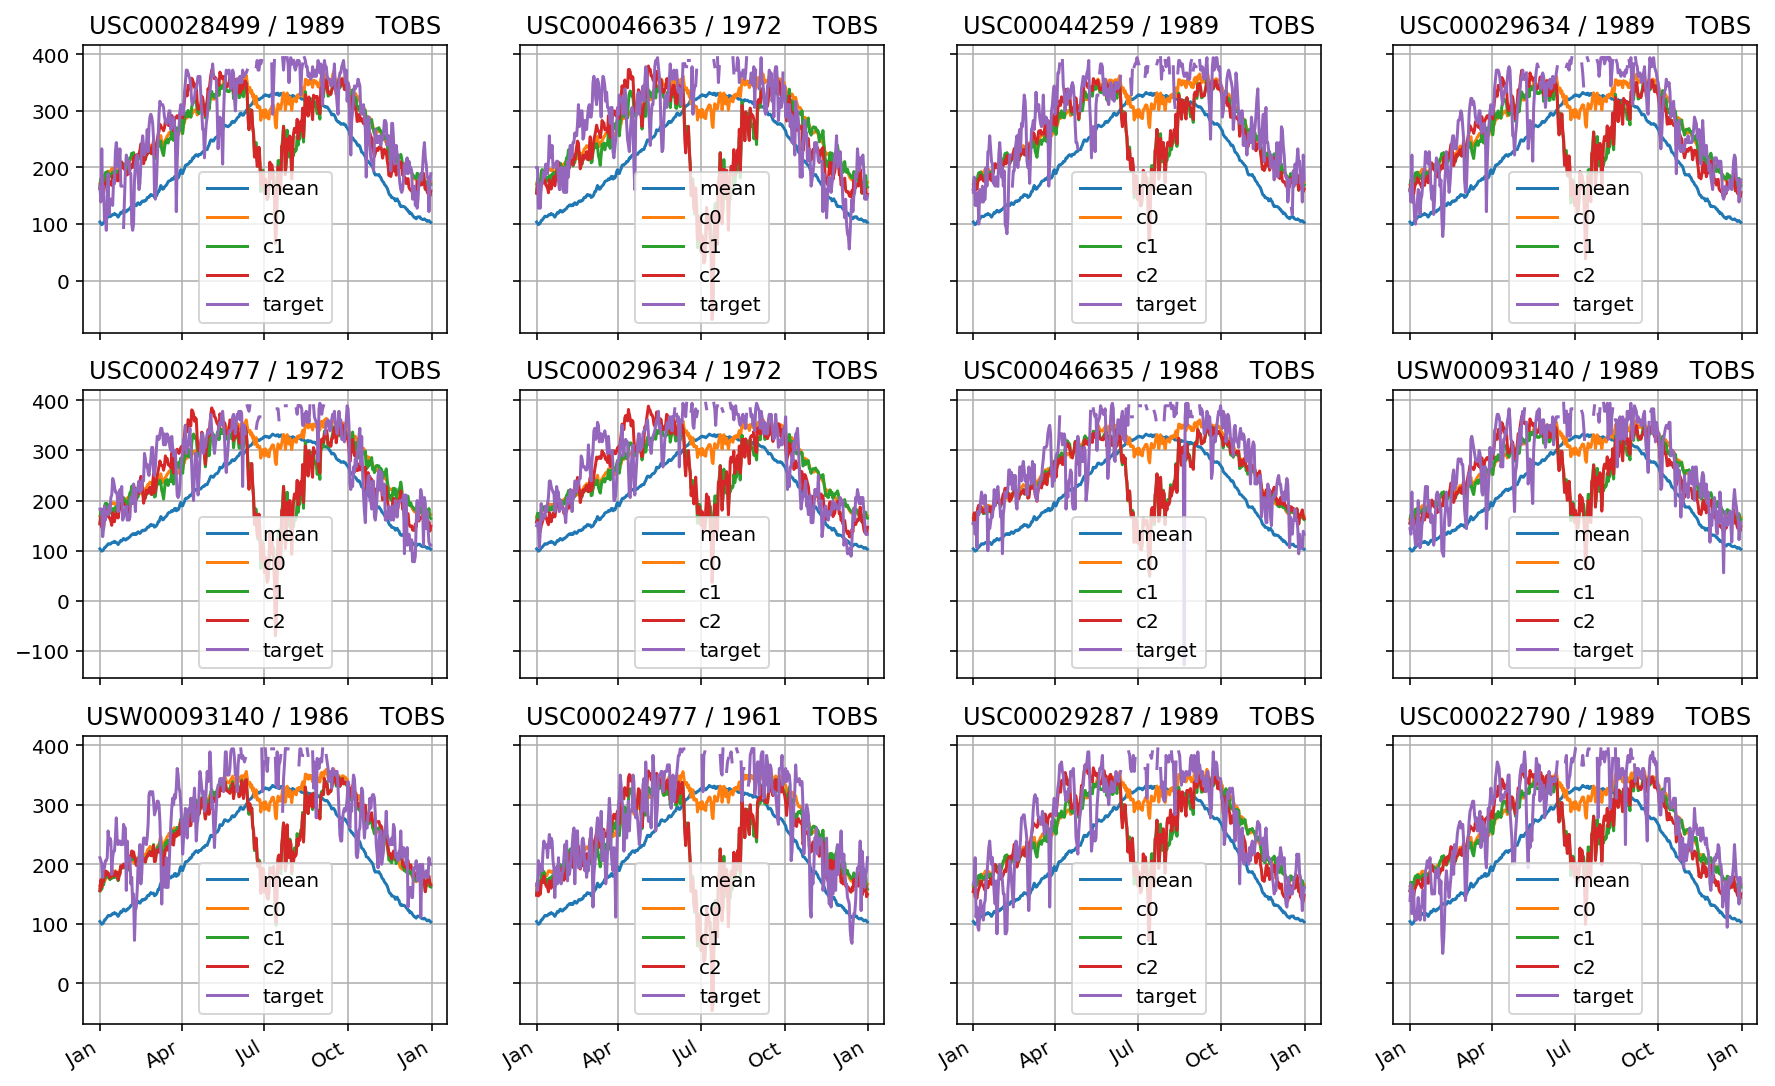

In [105]:
plot_recon_grid(rows)

In [102]:
df5=df3.filter(df3.res_1<0.4).sort(df3.coeff_1, ascending=False)
rows=df5.take(12)
df5.select('coeff_1','res_1').show(4)

+------------------+-------------------+
|           coeff_1|              res_1|
+------------------+-------------------+
|1837.5910047863367|0.25459494543574046|
|1809.8917806283753| 0.2817150650628105|
|1785.1075690542698| 0.2724742363767796|
| 1733.899315939388|0.23799882575609188|
+------------------+-------------------+
only showing top 4 rows



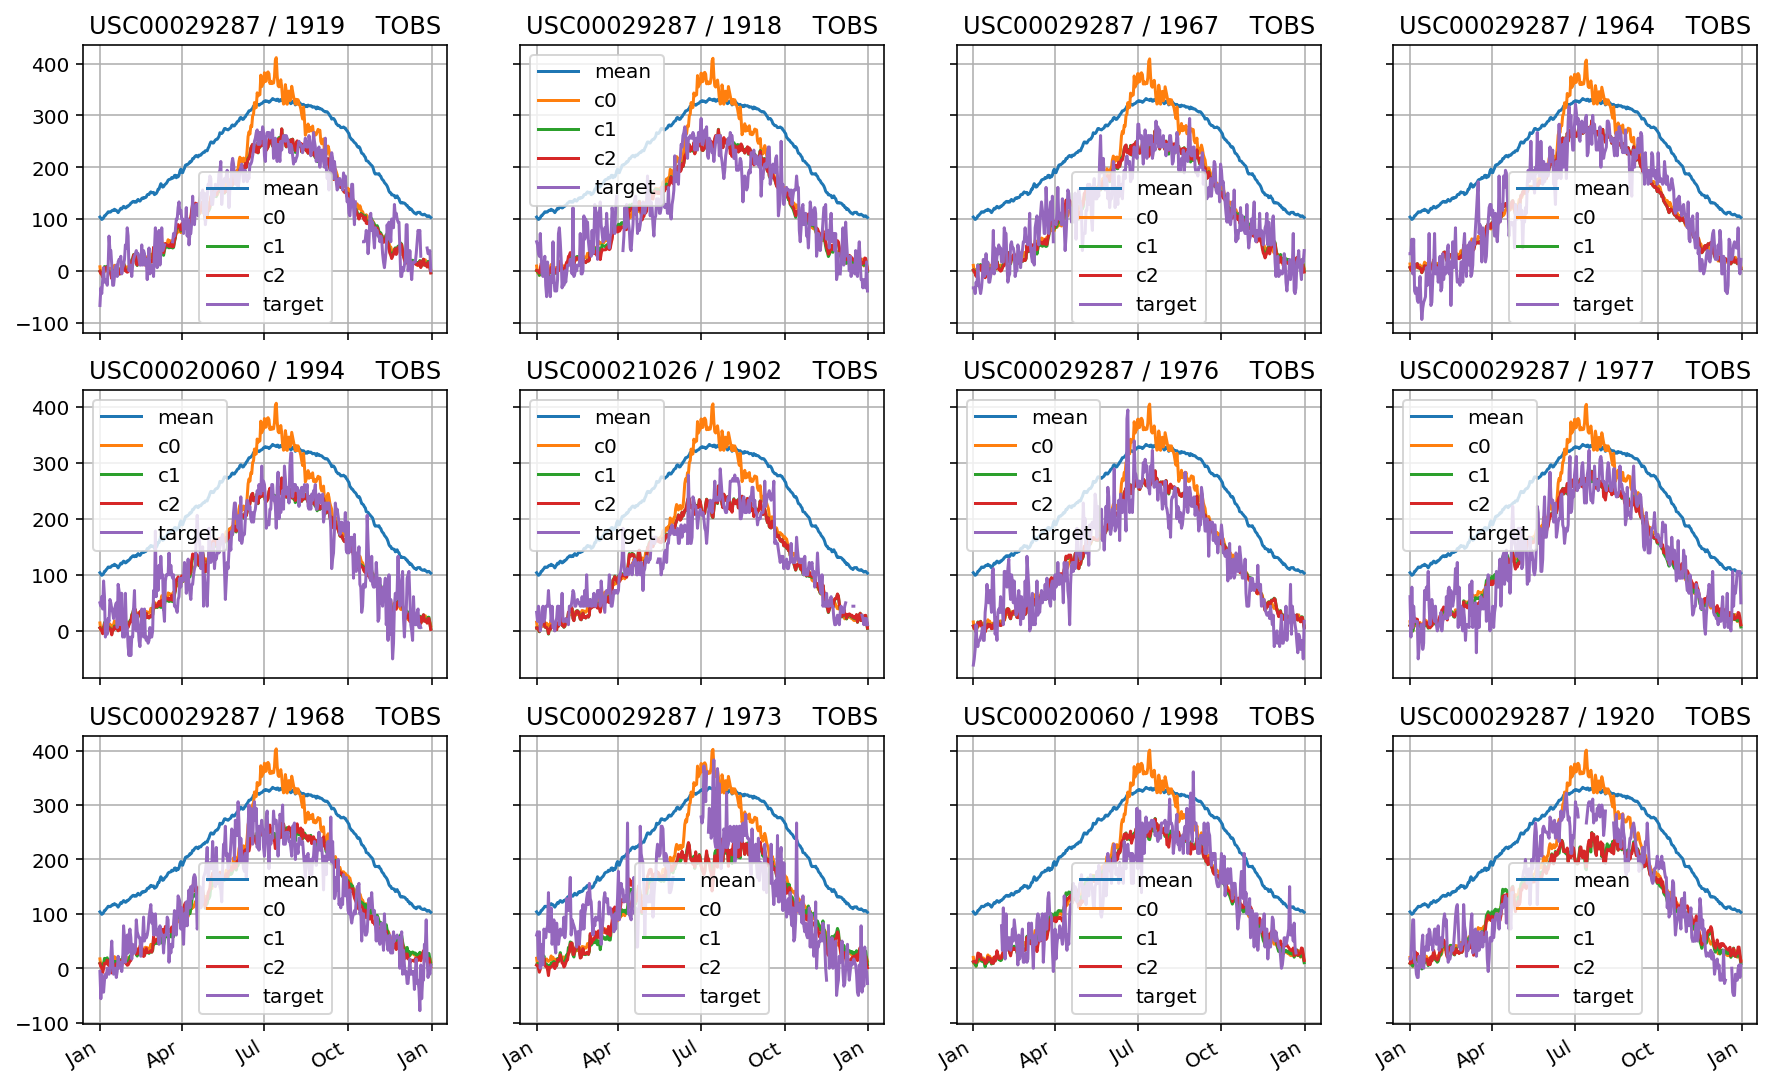

In [103]:
plot_recon_grid(rows)

In [106]:
df3.filter(df3.res_1<0.4).count()

198

In [125]:
df4=df3.filter(df3.res_2<0.6).sort(df3.coeff_2)
rows=df4.take(12)
df4.select('station','year','coeff_2','res_2', 'coeff_1').show(4)

+-----------+------+-------------------+-------------------+------------------+
|    station|  year|            coeff_2|              res_2|           coeff_1|
+-----------+------+-------------------+-------------------+------------------+
|USC00022462|1955.0|-1871.2184473473887|0.41599489434169695|1253.0787636848488|
|USC00027460|1911.0| -1240.738500111339| 0.4494416936122674|1116.5204572787638|
|USC00022462|1956.0|-1176.8011449182054|0.26982025831051987|1292.1102875409135|
|USC00029287|1973.0|-1161.2975439348202| 0.3192334584439766|1633.4165014214734|
+-----------+------+-------------------+-------------------+------------------+
only showing top 4 rows



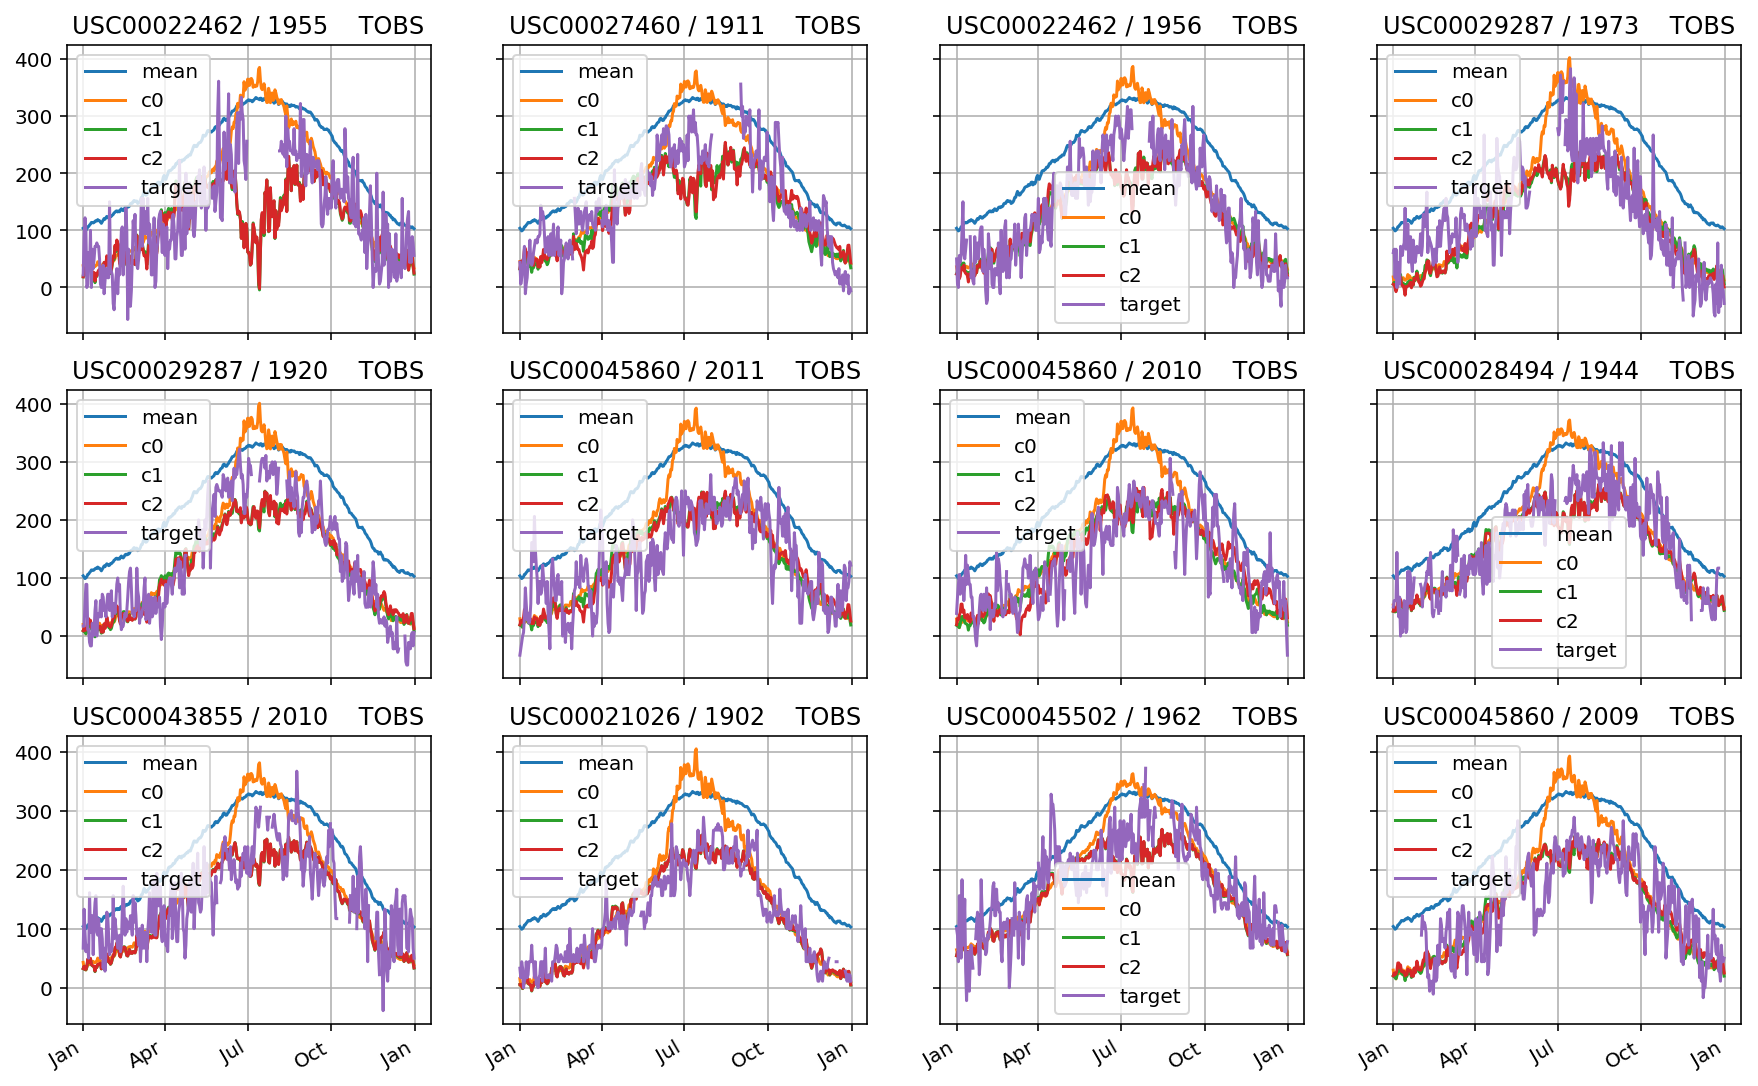

In [112]:
plot_recon_grid(rows)

In [22]:
df3.sort?

In [126]:
df5=df3.filter(df3.res_2<0.6).sort(df3.coeff_2,ascending=False)
rows=df5.take(12)
df5.select('station','year','coeff_2','res_2', 'coeff_1').show(4)

+-----------+------+------------------+------------------+------------------+
|    station|  year|           coeff_2|             res_2|           coeff_1|
+-----------+------+------------------+------------------+------------------+
|USC00028112|2002.0| 292.9100282706805|0.3232864604860019|-848.1323346363404|
|USC00022927|1966.0| 282.1602597567824|0.5924333947699456|-447.0810243046918|
|USC00028112|2004.0|265.03257181517876|0.3887194464613411|-835.8790377246141|
|USC00028112|1991.0| 264.8989014787868|0.4485906633669739|-685.6394504913202|
+-----------+------+------------------+------------------+------------------+
only showing top 4 rows



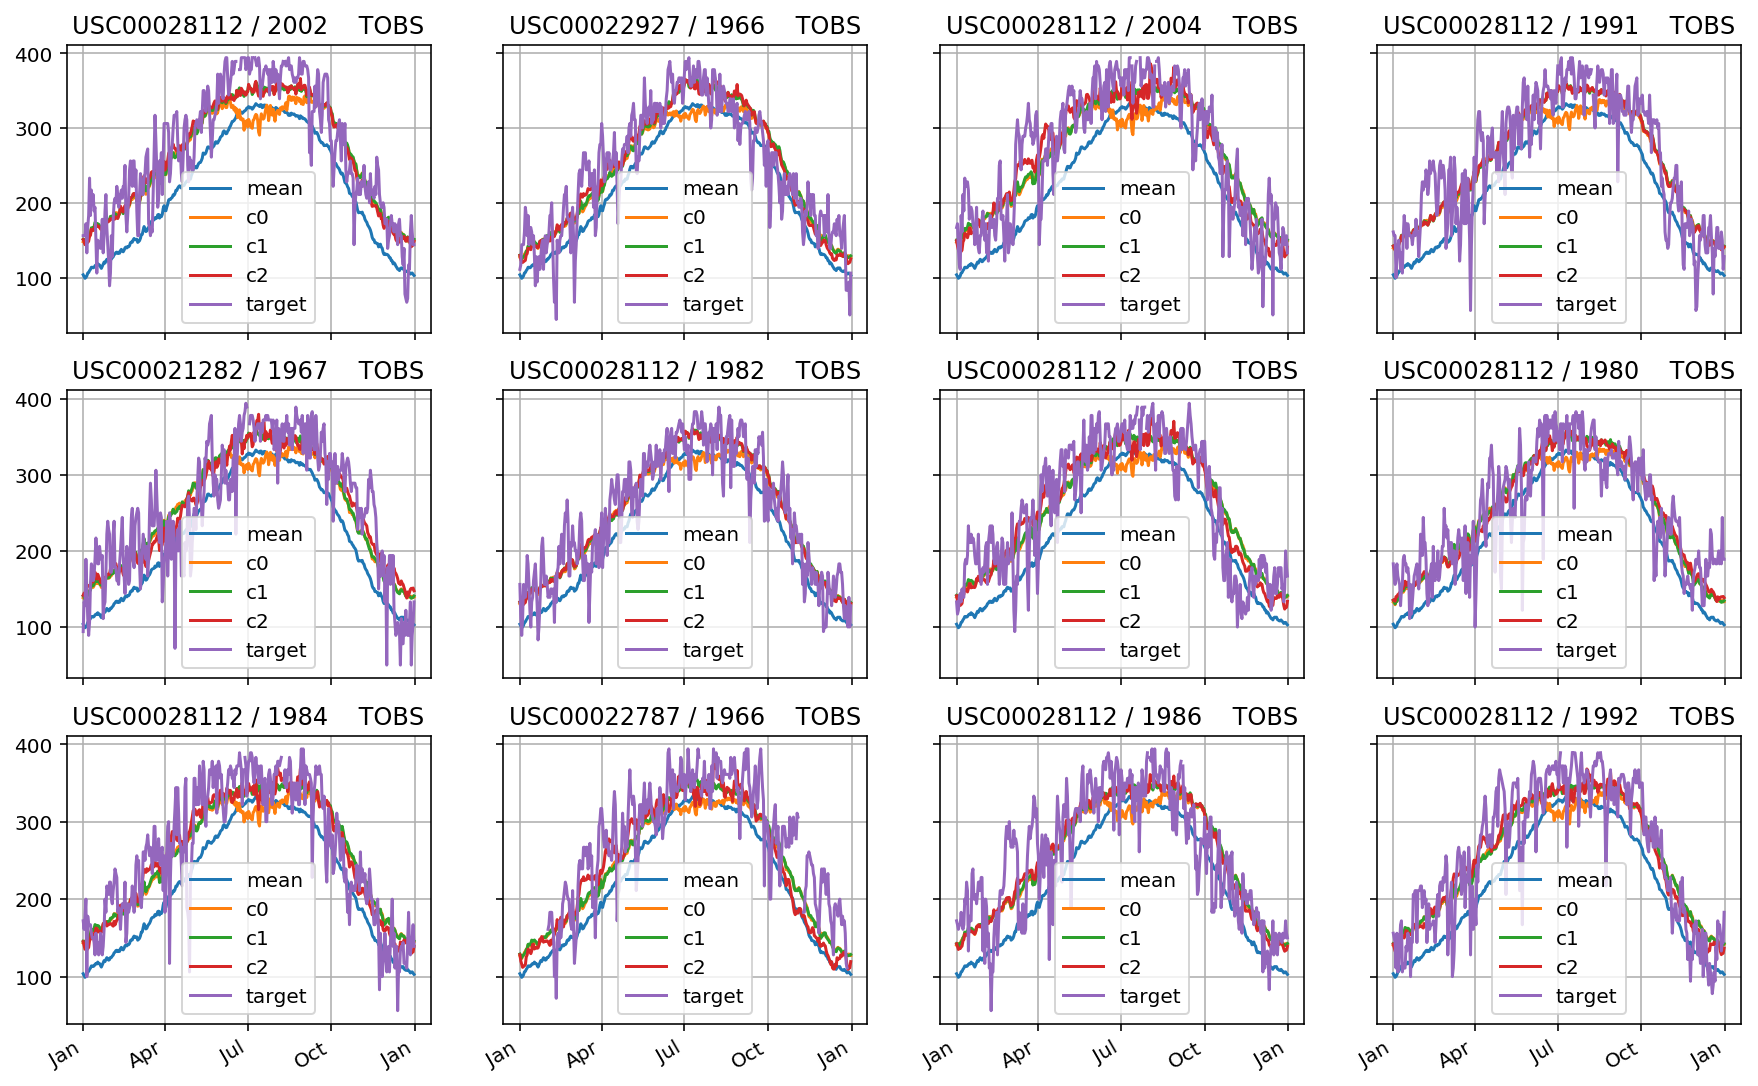

In [110]:
plot_recon_grid(rows)

In [131]:
df6=df3.filter(df3.res_3<0.4).sort(df3.coeff_3)
rows=df6.take(12)
df6.select('station','year','res_2','coeff_3','res_3').show(4)

+-----------+------+-------------------+-------------------+-------------------+
|    station|  year|              res_2|            coeff_3|              res_3|
+-----------+------+-------------------+-------------------+-------------------+
|USC00020060|2000.0|0.23618197421804243|-372.49649231131355| 0.1924170254056361|
|USC00028499|1972.0|0.39748741902648965| -355.4961479987022| 0.2997216009189838|
|USC00029287|1956.0| 0.2875587045042562| -352.5201605871948|0.22882564242316794|
|USC00028489|1972.0| 0.3523433075167629|-317.03280777906514| 0.2710263922294451|
+-----------+------+-------------------+-------------------+-------------------+
only showing top 4 rows



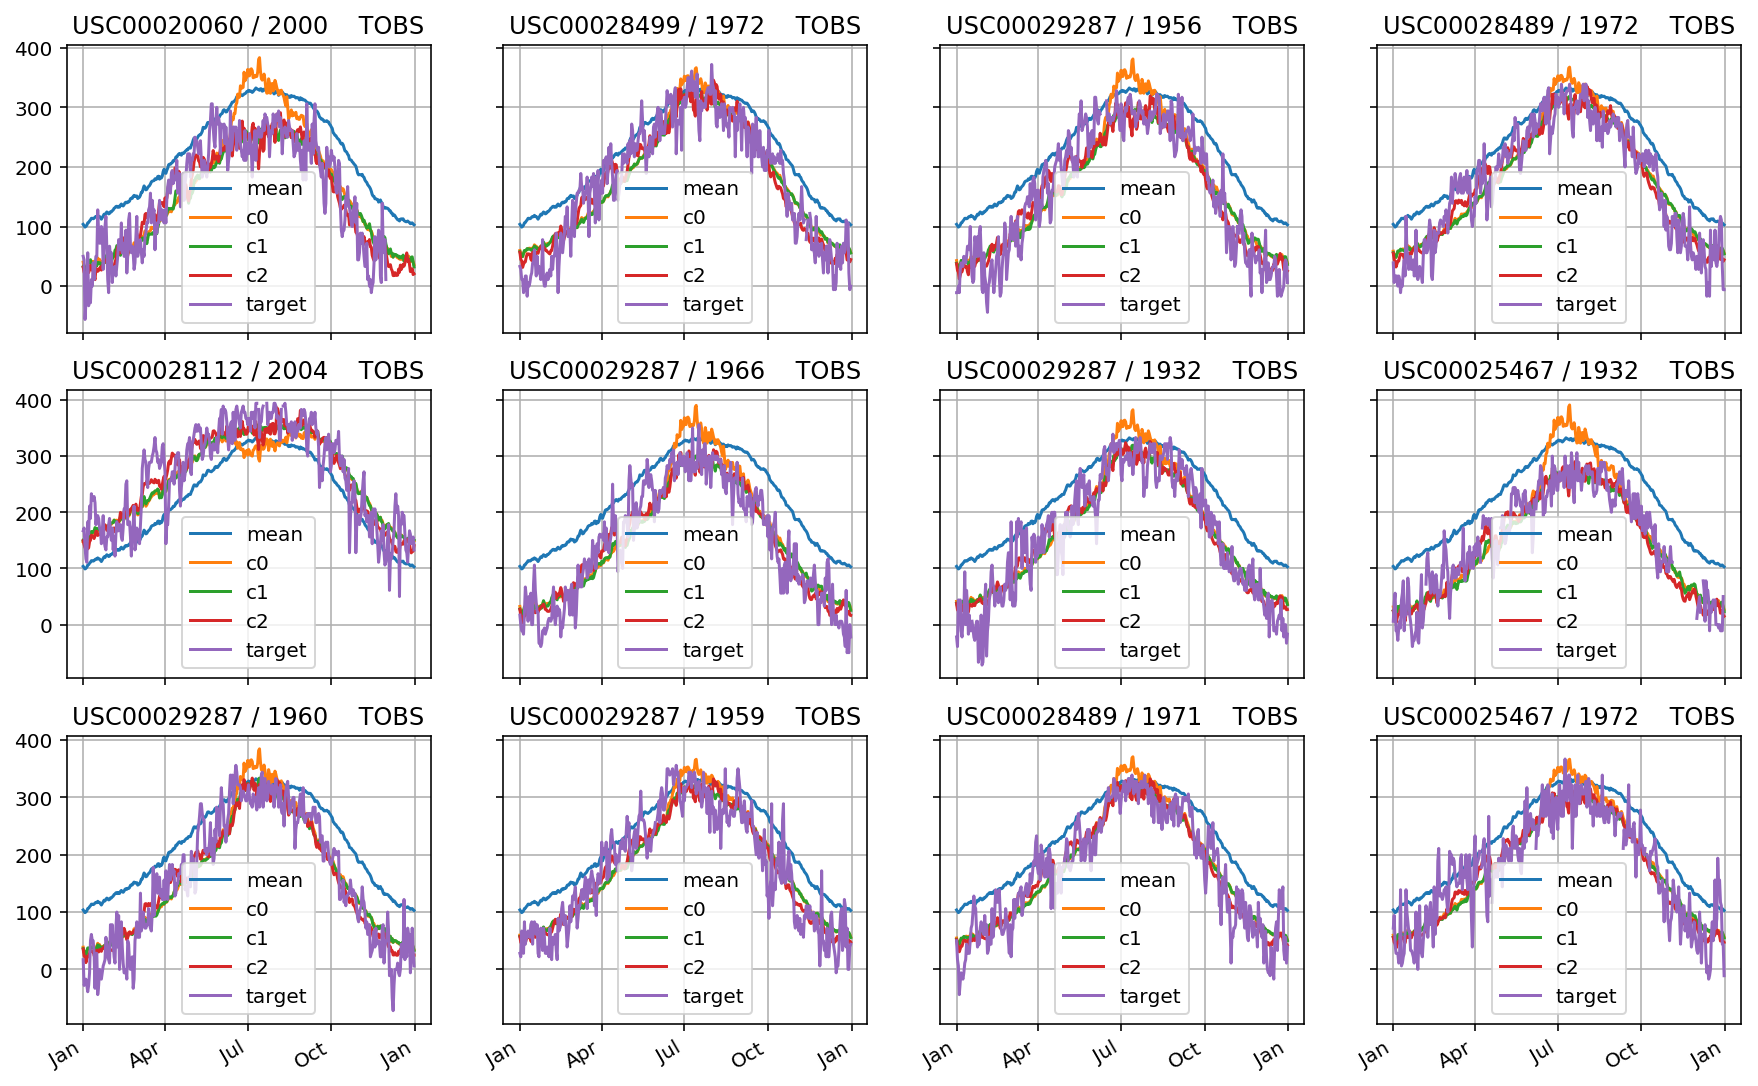

In [120]:
plot_recon_grid(rows)

In [132]:
df6=df3.filter(df3.res_3<0.4
).sort(df3.coeff_3, ascending=False)
rows=df6.take(12)
df6.select('station','year','res_2','coeff_3','res_3').show(4)

+-----------+------+-------------------+------------------+-------------------+
|    station|  year|              res_2|           coeff_3|              res_3|
+-----------+------+-------------------+------------------+-------------------+
|USC00045860|2010.0|  0.237312559403574| 409.8176596249946|0.20108238278605792|
|USC00022462|1959.0|0.17223272008850515|314.03938676736533| 0.1844530377649019|
|USC00022462|1983.0|0.36232996907284126|304.25147921855245|  0.304373939282402|
|USC00045860|2012.0|0.24844924072638191| 298.2044806751376|0.21830214915573282|
+-----------+------+-------------------+------------------+-------------------+
only showing top 4 rows



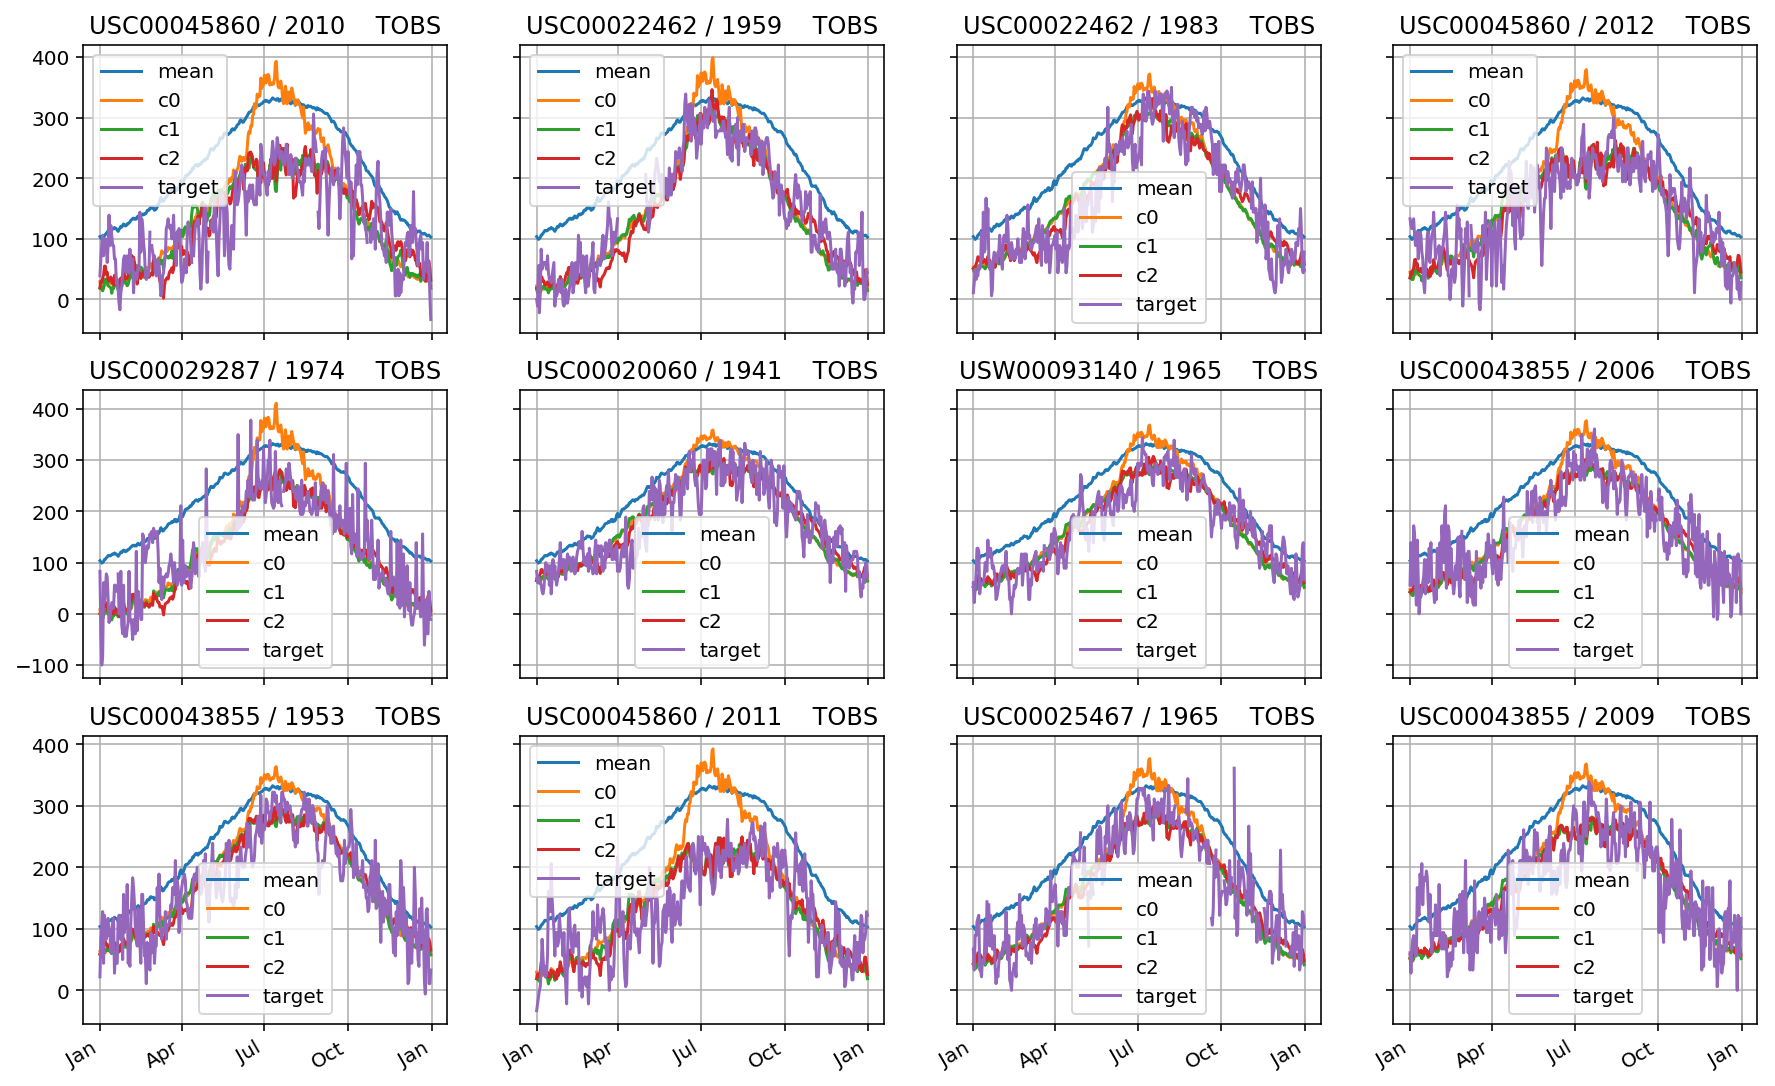

In [122]:
plot_recon_grid(rows)

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

residual normalized norm  after mean: 0.0454224916053
residual normalized norm  after mean + top eigs: [ 0.46595098  0.32328646  0.3152042 ]


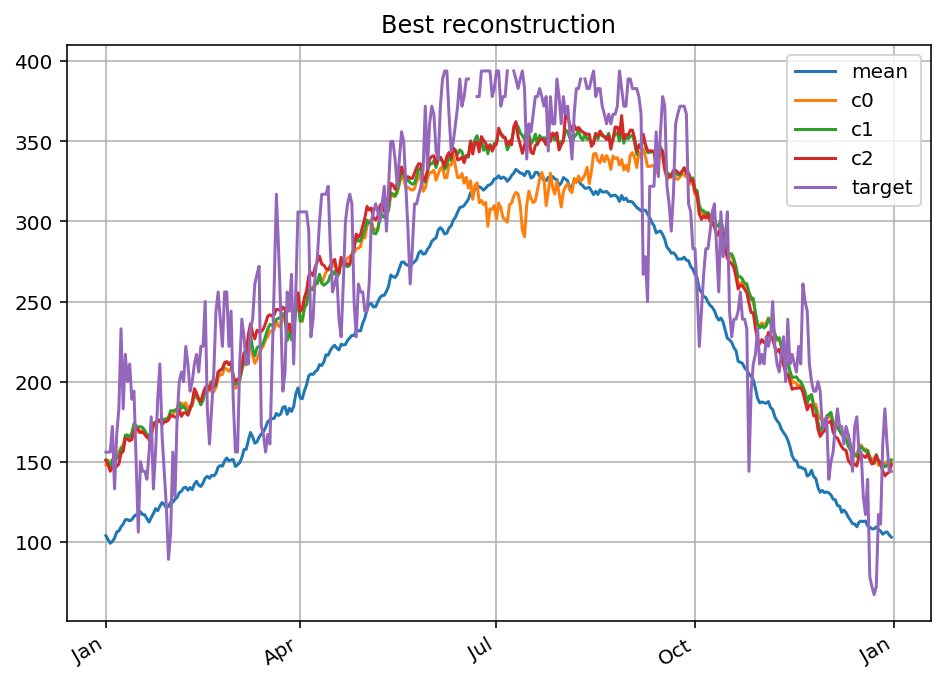

In [25]:
row=rows[0]
target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
eigen_decomp=Eigen_decomp(None,target,Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

### What is the distribution of the residuals and the coefficients?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [28]:
# A function for plotting the CDF of a given feature
def plot_CDF(feat):
    rows=df3.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)))
    #vals=[vals[0]]+vals
    plot(vals,P)
    title('cumulative distribution of '+feat)
    ylabel('number of instances')
    xlabel(feat)
    grid()

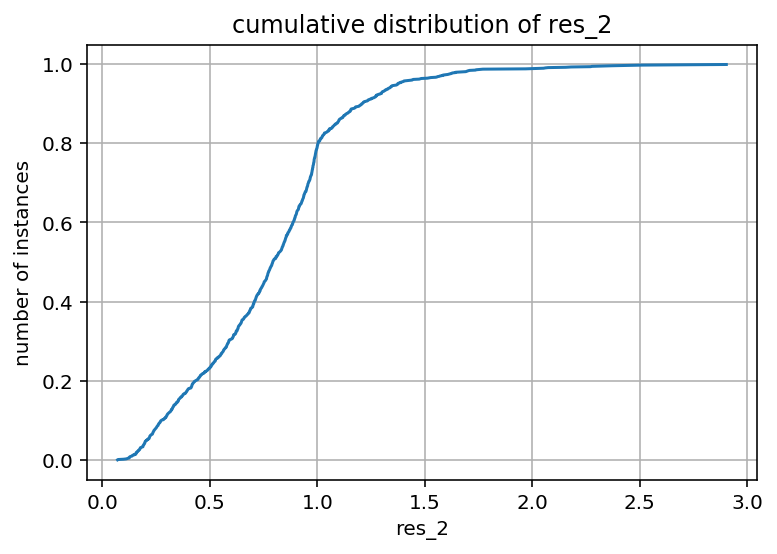

In [29]:
plot_CDF('res_2')

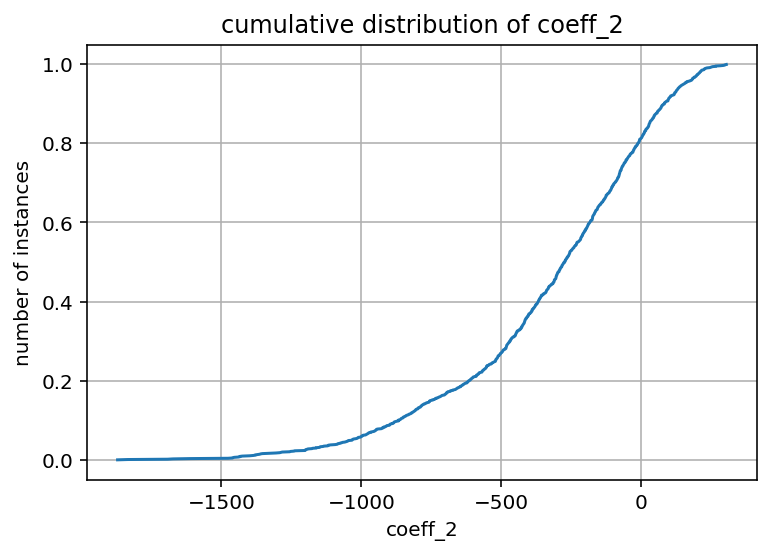

In [30]:
plot_CDF('coeff_2')

In [31]:
filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)

In [32]:
!du -sh $data_dir/*.parquet

2.9M	../../Data/Weather/US_Weather_SSSSSSBB.parquet
3.1M	../../Data/Weather/decon_SSSSSSBB_PRCP.parquet
276K	../../Data/Weather/decon_SSSSSSBB_SNWD.parquet
3.1M	../../Data/Weather/decon_SSSSSSBB_TOBS.parquet


In [35]:
df3.toPandas()

coeff_1     coeff_2     coeff_3  elevation     label  latitude  \
0     0.481323   -0.445516 -310.702415     1229.0  SSSSSSBB   33.5833   
1  -785.382482    0.202109   -0.050314     1229.0  SSSSSSBB   33.5833   
2     0.676954  470.587636   -0.168084      780.9  SSSSSSBB   34.0333   
3   -34.472187   -0.235896    0.130649      417.6  SSSSSSBB   33.7044   
4   -86.870301   -0.213964    0.129575      580.0  SSSSSSBB   33.7833   
5     0.414160   11.827737    0.128120      509.0  SSSSSSBB   33.7167   
6     0.420958   21.891062    0.123265      780.9  SSSSSSBB   34.0333   
7     0.419389   14.839124    0.134050      417.6  SSSSSSBB   33.7044   
8    -7.753674   -0.252000    0.137647      780.9  SSSSSSBB   34.0333   
9     0.471592   28.499771    0.335275      -54.9  SSSSSSBB   33.5714   
10    0.439723   14.193238    0.236799      351.1  SSSSSSBB   33.4333   
11    0.424055    6.989088    0.188310      780.9  SSSSSSBB   34.0333   
12    0.412243   -0.265831    0.181970      659.9  SSSSSSBB   33.9433   
13    0.407946   -0.255657    0.138251      638.6  SSSSSSBB   33.9792   
14    0.407942   -0.255649    0.138241      659.9  SSSSSSBB   33.9433   
15    0.407942   -0.255649    0.138241      771.1  SSSSSSBB   33.8161   
16    0.407941   -0.255649    0.138241      780.9  SSSSSSBB   34.0333   
17    0.408354   -0.256374    0.139164      365.8  SSSSSSBB   33.6514   
18    0.409239   -0.257934    0.141177      638.6  SSSSSSBB   33.9792   
19    0.409227   -0.257914    0.141151      580.0  SSSSSSBB   33.7833   
20    0.411348   -0.261707    0.146182      659.9  SSSSSSBB   33.9433   
21    0.468441   -0.396749    0.726219      780.9  SSSSSSBB   34.0333   
22    0.433395   -0.305861    0.224909      780.9  SSSSSSBB   34.0333   

    longitude measurement     res_1     res_2     res_3  res_mean  \
0   -116.4333        SNWD  0.999998  0.999996  0.000004  0.999118   
1   -116.4333        SNWD  0.000187  0.000187  0.000187  0.998964   
2   -116.5833        SNWD  0.999998  0.001203  0.001203  0.998942   
3   -115.6289        SNWD  0.356248  0.356218  0.356209  0.984505   
4   -113.6167        SNWD  0.547462  0.547459  0.547458  0.995335   
5   -112.0500        SNWD  0.999723  0.773951  0.773925  0.991410   
6   -116.5833        SNWD  0.999945  0.850849  0.850844  0.996329   
7   -115.6289        SNWD  0.999972  0.965509  0.965506  0.998182   
8   -116.5833        SNWD  0.976817  0.976792  0.976785  0.997013   
9   -116.0767        SNWD  0.999995  0.980249  0.980246  0.998213   
10  -111.9333        SNWD  0.999981  0.980550  0.980545  0.996459   
11  -116.5833        SNWD  0.999944  0.984712  0.984701  0.994157   
12  -113.1875        SNWD  0.999726  0.999612  0.999558  0.991410   
13  -112.7403        SNWD  0.999734  0.999629  0.999598  0.999592   
14  -113.1875        SNWD  0.999734  0.999629  0.999598  0.999602   
15  -111.9019        SNWD  0.999734  0.999629  0.999598  0.999602   
16  -116.5833        SNWD  0.999734  0.999629  0.999598  0.999602   
17  -116.3764        SNWD  0.999867  0.999814  0.999798  0.999350   
18  -112.7403        SNWD  0.999936  0.999910  0.999902  0.999225   
19  -113.6167        SNWD  0.999936  0.999910  0.999902  0.999231   
20  -113.1875        SNWD  0.999971  0.999959  0.999955  0.999158   
21  -116.5833        SNWD  0.999997  0.999995  0.999988  0.999043   
22  -116.5833        SNWD  0.999999  0.999997  0.999996  0.999115   

        station  total_var  undefs  \
0   USC00046196    96622.0       0   
1   USC00046196   617581.0      31   
2   USC00045863   221956.0      10   
3   USC00043855     1875.0       0   
4   USC00027453    16754.0       0   
5   USC00021365      625.0       0   
6   USC00045863     3226.0       0   
7   USC00043855     6401.0       0   
8   USC00045863     2601.0       1   
9   USC00045502    41209.0       3   
10  USC00028489    10404.0       0   
11  USC00045863     3226.0      11   
12  USC00020060      625.0      32   
13  USC00029287      625.0       1   
14  USC00020060      625.0 